# _Gradients_ Cruise Data

Here we retrieve [SCOPE-Gradients](http://scope.soest.hawaii.edu/data/gradients/data/) cruise data from the [Simons' CMAP](https://cmap.readthedocs.io/en/latest/) data base.

<img src="../figs/cbiomes-01.png" alt="Drawing" style="height: 100px;"/>

_Pre-requisites:_

- 1. _install the [PyCmap](https://github.com/simonscmap/pycmap) python package and its dependencies using `pip`_
- 2. _compile [PyCall.jl](https://github.com/simonscmap/pycmap) using external python distribution that installed `PyCmap`_
- 3. _obtain your own API key from the [SimonsCMAP website](https://simonscmap.com) (free; takes `<30s`)_
- 4. _import `pycmap` via `pycall`_

In [1]:
if false
    run(`pip install pycmap`) #pycmap is used via PyCall later
    run(pipeline(`which python`,"whichpython.txt")) #external python path
    ENV["PYTHON"]=readline("whichpython.txt")
    import Pkg; Pkg.build("PyCall")
end

### Import _pycmap_ Into _julia_

[PyCmap](https://github.com/simonscmap/pycmap) is the `Python` API that we will use in `julia` (to query the `CMAP` data base) via the [PyCall.jl](https://github.com/JuliaPy/PyCall.jl) package. 

_You may need to replace `your-own-API-key` (as outline below) with your own API key from the [SimonsCMAP website](https://simonscmap.com) and uncomment the command below._

In [2]:
using PyCall
PyCmap = pyimport("pycmap")
#cmap = PyCmap.API(token="your-own-API-key")
cmap = PyCmap.API()

PyObject <pycmap.cmap.API object at 0x7fd858e6b2d0>

### Get Data Catalog

_See [SimonsCMAP website](https://simonscmap.com) for more information. The commented `df.to_csv` call below creates `catalog.csv` and writes the data from `df` to this file._

In [3]:
df = cmap.get_catalog()
#df.to_csv("catalog.csv")

,Variable,Table_Name,Long_Name,Unit,Make,Sensor,Process_Level,Study_Domain,Temporal_Resolution,Spatial_Resolution,Time_Min,Time_Max,Lat_Min,Lat_Max,Lon_Min,Lon_Max,Depth_Min,Depth_Max,Variable_25th,Variable_50th,Variable_75th,Variable_Count,Variable_Mean,Variable_Std,Variable_Min,Variable_Max,Comment,Dataset_Name,Data_Source,Distributor,Dataset_Description,Acknowledgement,Dataset_ID,ID,Visualize,Keywords
0,vgosa,tblAltimetry_REP,Geostrophic velocity anomalies: meridian compo...,m/s,Observation,Satellite,Reprocessed,Physics,Daily,1/4Â° X 1/4Â°,1993-01-01T00:00:00.000Z,2018-06-10T00:00:00.000Z,-89.875000,89.875000,-179.8750,179.875,NaN,NaN,NaN,NaN,NaN,5.361397e+09,-8.547000e-07,0.142801,-4.995600,4.999000,The geostrophic velocity anomalies are referen...,Sea Surface Height and Derived Variables (Repr...,SL-TAC,http://marine.copernicus.eu/,The reprocessed altimetry dataset in CMAP was ...,Data was provided by: E.U. Copernicus Marine S...,8,2,1.0,"daily, geostrophic velocity anomalies, meridia..."
1,vgos,tblAltimetry_REP,Absolute geostrophic velocity: meridian component,m/s,Observation,Satellite,Reprocessed,Physics,Daily,1/4Â° X 1/4Â°,1993-01-01T00:00:00.000Z,2018-06-10T00:00:00.000Z,-89.875000,89.875000,-179.8750,179.875,NaN,NaN,NaN,NaN,NaN,5.337270e+09,1.365396e-03,0.153150,-5.485500,5.214400,surface_geostrophic_northward_sea_water_velocity,Sea Surface Height and Derived Variables (Repr...,SL-TAC,http://marine.copernicus.eu/,The reprocessed altimetry dataset in CMAP was ...,Data was provided by: E.U. Copernicus Marine S...,8,6,1.0,"daily, geostrophic, meridian component, observ..."
2,sla,tblAltimetry_REP,Sea Level Anomaly,m,Observation,Satellite,Reprocessed,Physics,Daily,1/4Â° X 1/4Â°,1993-01-01T00:00:00.000Z,2018-06-10T00:00:00.000Z,-89.875000,89.875000,-179.8750,179.875,NaN,NaN,NaN,NaN,NaN,5.494281e+09,3.448953e-02,0.091852,-1.745000,2.266100,The sea level anomaly is the sea surface heigh...,Sea Surface Height and Derived Variables (Repr...,SL-TAC,http://marine.copernicus.eu/,The reprocessed altimetry dataset in CMAP was ...,Data was provided by: E.U. Copernicus Marine S...,8,9,1.0,"daily, observation, physics, reprocessed, sate..."
3,adt,tblAltimetry_REP,Absolute Dynamic Topography,m,Observation,Satellite,Reprocessed,Physics,Daily,1/4Â° X 1/4Â°,1993-01-01T00:00:00.000Z,2018-06-10T00:00:00.000Z,-89.875000,89.875000,-179.8750,179.875,NaN,NaN,NaN,NaN,NaN,5.449859e+09,3.383828e-01,0.688690,-2.182100,2.834200,The absolute dynamic topography is the sea sur...,Sea Surface Height and Derived Variables (Repr...,SL-TAC,http://marine.copernicus.eu/,The reprocessed altimetry dataset in CMAP was ...,Data was provided by: E.U. Copernicus Marine S...,8,10,1.0,"absolute dynamic topography, adt, daily, obser..."
4,ugosa,tblAltimetry_REP,Geostrophic velocity anomalies: zonal component,m/s,Observation,Satellite,Reprocessed,Physics,Daily,1/4Â° X 1/4Â°,1993-01-01T00:00:00.000Z,2018-06-10T00:00:00.000Z,-89.875000,89.875000,-179.8750,179.875,NaN,NaN,NaN,NaN,NaN,5.361397e+09,1.676976e-04,2.936698,-214748.313500,4.992900,The geostrophic velocity anomalies are referen...,Sea Surface Height and Derived Variables (Repr...,SL-TAC,http://marine.copernicus.eu/,The reprocessed altimetry dataset in CMAP was ...,Data was provided by: E.U. Copernicus Marine S...,8,11,1.0,"daily, geostrophic velocity anomalies zonal co..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,PO4,tblKOK1606_Gradients1_Nutrients,Dissolved Phosphate,umol/L,Observation,In-Situ,Reprocessed,Biogeochemistry,Irregular,Irregular,2016-04-21T00:03:10.000Z,2016-05-03T20:39:10.000Z,23.571167,37.738333,-158.1565,-157.916,4.430837,992.367622,0.063617,0.218875,0.498452,9.700000e+01,2.863391e-01,0.223310,0.023459,0.687710,NaN,Cruise KOK1606 Gradients 1 Organic and Inorgan...,"University of Hawaii - Manoa, David Karl lab","University of Hawaii - Manoa, David Karl lab",All organic and inorganic nut

### Download Data

The lists provided below contain `CMAP table` names associated with the [SCOPE-Gradients](http://scope.soest.hawaii.edu/data/gradients/data/) cruise data. 

_Uncomment one code bloc at a time to download more files._

In [4]:
pth="../samples/gradients/"
!isdir("$pth") ? mkdir("$pth") : nothing

list0=[]
if !isfile("$pth"*"tblKM1906_Gradients3_uway_optics.csv")
    list0=["tblKM1906_Gradients3","tblKM1906_Gradients3_uway_optics","tblKM1906_Gradients3_uwayCTD","tblKM1906_Gradients3_uw_tsg",
        "tblMGL1704_Gradients2_CTD","tblMGL1704_Gradients2_uway_optics","tblKOK1606_Gradients1_CTD","tblKOK1606_Gradients1_uway_optics"]
end

#list0=["tblMGL1704_Gradients2_Nutrients","tblMGL1704_Gradients2_Diazotroph",
#    "tblMGL1704_Gradients2_TargetedMetabolites","tblMGL1704_Gradients2_Trace_Metals"]

#list0=["tblKOK1606_Gradients1_Nutrients","tblKOK1606_Gradients1_Dissolved_Gasses",
#    "tblKOK1606_Gradients1_TargetedMetabolites","tblKOK1606_Gradients1_Diazotroph"]

for i in list0
    df=cmap.get_dataset(i)
    df.to_csv("$pth$i.csv")
end

### Read Data, Get Meta-Data, And Plot

As a use case example below we read the `LISST` data collected during the `Gradients 2` cruise and plot a subset of the data.

In [5]:
using CSV, DataFrames
df = CSV.File("$pth"*"tblKM1906_Gradients3_uway_optics.csv") |> DataFrame! ;

In [6]:
cmap.get_dataset_metadata("tblKM1906_Gradients3_uway_optics")
cmap.get_metadata("tblKM1906_Gradients3_uway_optics","LISST_small")
u=cmap.get_unit("tblKM1906_Gradients3_uway_optics", "LISST_small")

" [umol C/L]"

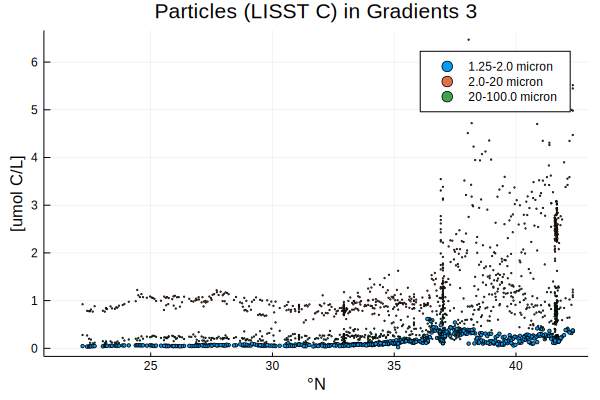

In [7]:
using Plots

tmp=df[1:10:end,:]
scatter(tmp[!,:lat],tmp[!,:LISST_small],marker = 2,label="1.25-2.0 micron",
    xlabel="°N",ylabel=u,title="Particles (LISST C) in Gradients 3")
scatter!(tmp[!,:lat],tmp[!,:LISST_medium],marker = 1,label="2.0-20 micron")
scatter!(tmp[!,:lat],tmp[!,:LISST_large],marker = 1,label="20-100.0 micron")